## Imports

In [1]:
import os
import sys
sys.path.append(os.path.join('..', 'src'))

from data_loaders.melbourne_pedestrian import MelbounePedestrianDataModule

In [2]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
import json
import torch

In [3]:
def parse_config(config_file_name):
    """
    Load json config
    """
    try:
        with open(config_file_name, "r", encoding="utf-8") as file:
            return json.load(file)
    except FileNotFoundError:
        print(f"Error: The file '{config_file_name}' was not found.")
        return
    except json.JSONDecodeError:
        print(f"Error: The file '{config_file_name}' is not a valid JSON file.")
        return

In [4]:
config = {   
    "dataset_name": "melbourne_pedestrian",
    "dataset_config": {},
    "loader_config": {
                        "batch_size": 32,
                        "num_workers": 20,
                        "pin_memory": True
                    }
}

In [5]:
output_data_dir = os.path.join("..", "data", "melbourne_pedestrian")
if not os.path.exists(output_data_dir):
    os.makedirs(output_data_dir)

data_module = MelbounePedestrianDataModule(config["dataset_config"], loader_config=config["loader_config"])
dataset = data_module.train_dataset
labels = dataset.unique_labels
df = dataset.download_data("train")

## MSM Distance

### Funciones

In [6]:
def C(xi, x_prev, yj, c):
    if x_prev <= xi <= yj or x_prev >= xi >= yj:
        return c  # move is the best option
    else:
        return c + min(abs(xi - x_prev), abs(xi - yj))

def MSM_Distance(X, Y, c=0.1, verbose=False, return_cost=False):
    """
    Calculate the Move-Split-Merge (MSM) distance between two time series.
    Parameters:
    X (np.array): The first time series.
    Y (np.array): The second time series.
    c (float): The cost of the operations (move). Default is 0.1.
    return__cost (bool): If True, return the cost matrix. Default is False.
    verbose (bool): If True, log the operations. Default is False.
    Returns:
    tuple: The MSM distance between the two time series.
    """
    m = len(X)
    n = len(Y)
    Cost = np.zeros((m, n))

    # Initialization
    Cost[0, 0] = abs(X[0] - Y[0])
    if verbose:
        print(f"Init: Cost[0,0] = |{X[0]} - {Y[0]}| = {Cost[0, 0]}")

    for i in range(1, m):
        Cost[i, 0] = Cost[i - 1, 0] + C(X[i], X[i - 1], Y[0], c)
        if verbose:
            print((f"Init: Cost[{i},0] = Cost[{i - 1},0] + C({X[i]},"
                   f"{X[i - 1]}, {Y[0]}, {c}) = {Cost[i, 0]}"))

    for j in range(1, n):
        Cost[0, j] = Cost[0, j - 1] + C(Y[j], Y[j - 1], X[0], c)
        if verbose:
            print((f"Init: Cost[0,{j}] = Cost[0,{j - 1}] + C({Y[j]},"
                   f"{Y[j - 1]}, {X[0]}, {c}) = {Cost[0, j]}"))

    # Main Loop
    for i in range(1, m):
        for j in range(1, n):
            # diagonal movement in the cost matrix. This operation considers
            # the cost of matching the ith element in the time series X with
            # the jth element in Y.
            move_cost = Cost[i - 1, j - 1] + abs(X[i] - Y[j])

            # vertical movement in the cost matrix. This operation considers
            # the cost of potentially merging the ith element in the time
            # series X with the (i−1)th element before matching it with the
            # jth element in Y.
            merge_cost = Cost[i - 1, j] + C(X[i], X[i - 1], Y[j], c)

            # horizontal movement in the cost matrix. This operation accounts
            # for the cost of potentially splitting the jth element in the
            # time series Y to align with the ith element in X.
            split_cost = Cost[i, j - 1] + C(Y[j], X[i], Y[j - 1], c)

            Cost[i,j] = min(move_cost, merge_cost, split_cost)

            if verbose:
                print(
                    (f"Cost[{i},{j}]:  min(Move: "
                     f"{move_cost}, Merge: {merge_cost}, Split: "
                     f"{split_cost}) = {Cost[i, j]}")
                )

    if return_cost:
        return Cost[-1, -1], Cost
    else:
        return Cost[-1, -1]

def plot_cost_matrix(cost_matrix, alignment, X, Y):
    n, m = cost_matrix.shape
    
    # Create a color map for the cost matrix
    cmap = plt.cm.get_cmap('viridis')
    
    # Plot the cost matrix
    fig, ax = plt.subplots(figsize=(30, 20))
    im = ax.imshow(cost_matrix, cmap=cmap, aspect='auto')
    
    # Add colorbar
    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.ax.set_label('Cost')
    
    # Add labels and title
    ax.set_xticks(np.arange(m))
    ax.set_yticks(np.arange(n))
    ax.set_xticklabels(Y)
    ax.set_yticklabels(X)
    ax.set_xlabel('Time Series Y')
    ax.set_ylabel('Time Series X')
    ax.set_title('Cost Matrix with Best Alignment')
    
    # Highlight the best alignment path
    for i, j in alignment:
        ax.add_patch(plt.Rectangle((j-0.5, i-0.5), 1, 1, fill=False, edgecolor='red', lw=2))
    
    # Add cost matrix values to each cell
    for i in range(n):
        for j in range(m):
            ax.text(j, i, round(cost_matrix[i, j], 2), ha="center", va="center", color="w")
    
    plt.tight_layout()
    plt.show()

def compute_path(cost_matrix):
    n, m = cost_matrix.shape
    alignment = []
    i, j = n - 1, m - 1
    
    while i > 0 or j > 0:
        alignment.append((i, j))
        if i == 0:
            j -= 1
        elif j == 0:
            i -= 1
        else:
            min_index = np.argmin((cost_matrix[i-1, j-1], cost_matrix[i-1, j], cost_matrix[i, j-1]))
            if min_index == 0:
                i -= 1
                j -= 1
            elif min_index == 1:
                i -= 1
            else:
                j -= 1
    
    alignment.append((0, 0))
    return list(reversed(alignment))

### Ejemplo

In [7]:
input_data = []
data_loader = data_module.train_dataloader()

while len(input_data) < 2:
    batch = next(iter(data_loader))
    input_data = batch["input"]

    target_data = batch["label"]
    target_data = target_data.argmax(dim=1).numpy()

    label_reps = np.bincount(target_data)
    most_common_label = np.argmax(label_reps)
    most_common_label_indices = np.where(target_data == most_common_label)[0]

    input_data = input_data[most_common_label_indices]
    target_data = target_data[most_common_label_indices]

    print(f"Most common label: {most_common_label}")
    print(f"Most common label count: {len(most_common_label_indices)}")
    
X1 = input_data[0][0]
X2 = input_data[1][0]

Most common label: 3
Most common label count: 5


In [8]:
c = 1  # Cost parameter
distance, cost_matrix = MSM_Distance(X1, X2, c, return_cost=True, verbose=False)
print(f"X1: {X1}")
print(f"X2: {X2}")
print("The MSM distance is:", distance)
print("The cost matrix is:\n", cost_matrix)

X1: tensor([-0.9645, -0.9841, -0.9919, -0.9924, -0.9880, -0.9484, -0.8432, -0.5873,
        -0.1304, -0.5175, -0.7251, -0.6732, -0.5057, -0.4690, -0.5064, -0.5092,
        -0.2913,  0.1162, -0.2589, -0.5309, -0.6396, -0.6708, -0.6668, -0.7309])
X2: tensor([-0.9413, -0.9707, -0.9888, -0.9919, -0.9864, -0.9490, -0.8079, -0.5472,
        -0.0681, -0.5245, -0.7164, -0.6741, -0.4832, -0.5030, -0.5741, -0.5433,
        -0.3746,  0.1313, -0.3744, -0.6321, -0.7015, -0.7102, -0.7926, -0.8525])
The MSM distance is: 1.0188990831375122
The cost matrix is:
 [[2.31333375e-02 1.02932978e+00 2.04750586e+00 3.05060410e+00
  4.05060410e+00 5.06609488e+00 6.20716667e+00 7.46782970e+00
  8.94701958e+00 9.94701958e+00 1.09470196e+01 1.19893618e+01
  1.31802120e+01 1.41802120e+01 1.51802120e+01 1.62109871e+01
  1.73797359e+01 1.88855705e+01 1.98855705e+01 2.08855705e+01
  2.18855705e+01 2.28855705e+01 2.38855705e+01 2.48855705e+01]
 [1.04275537e+00 3.65589261e-02 1.03408039e+00 2.03717852e+00
  3.03717852e+

C:\Users\pepe1\AppData\Local\Temp\ipykernel_40240\2407588249.py:77: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis')


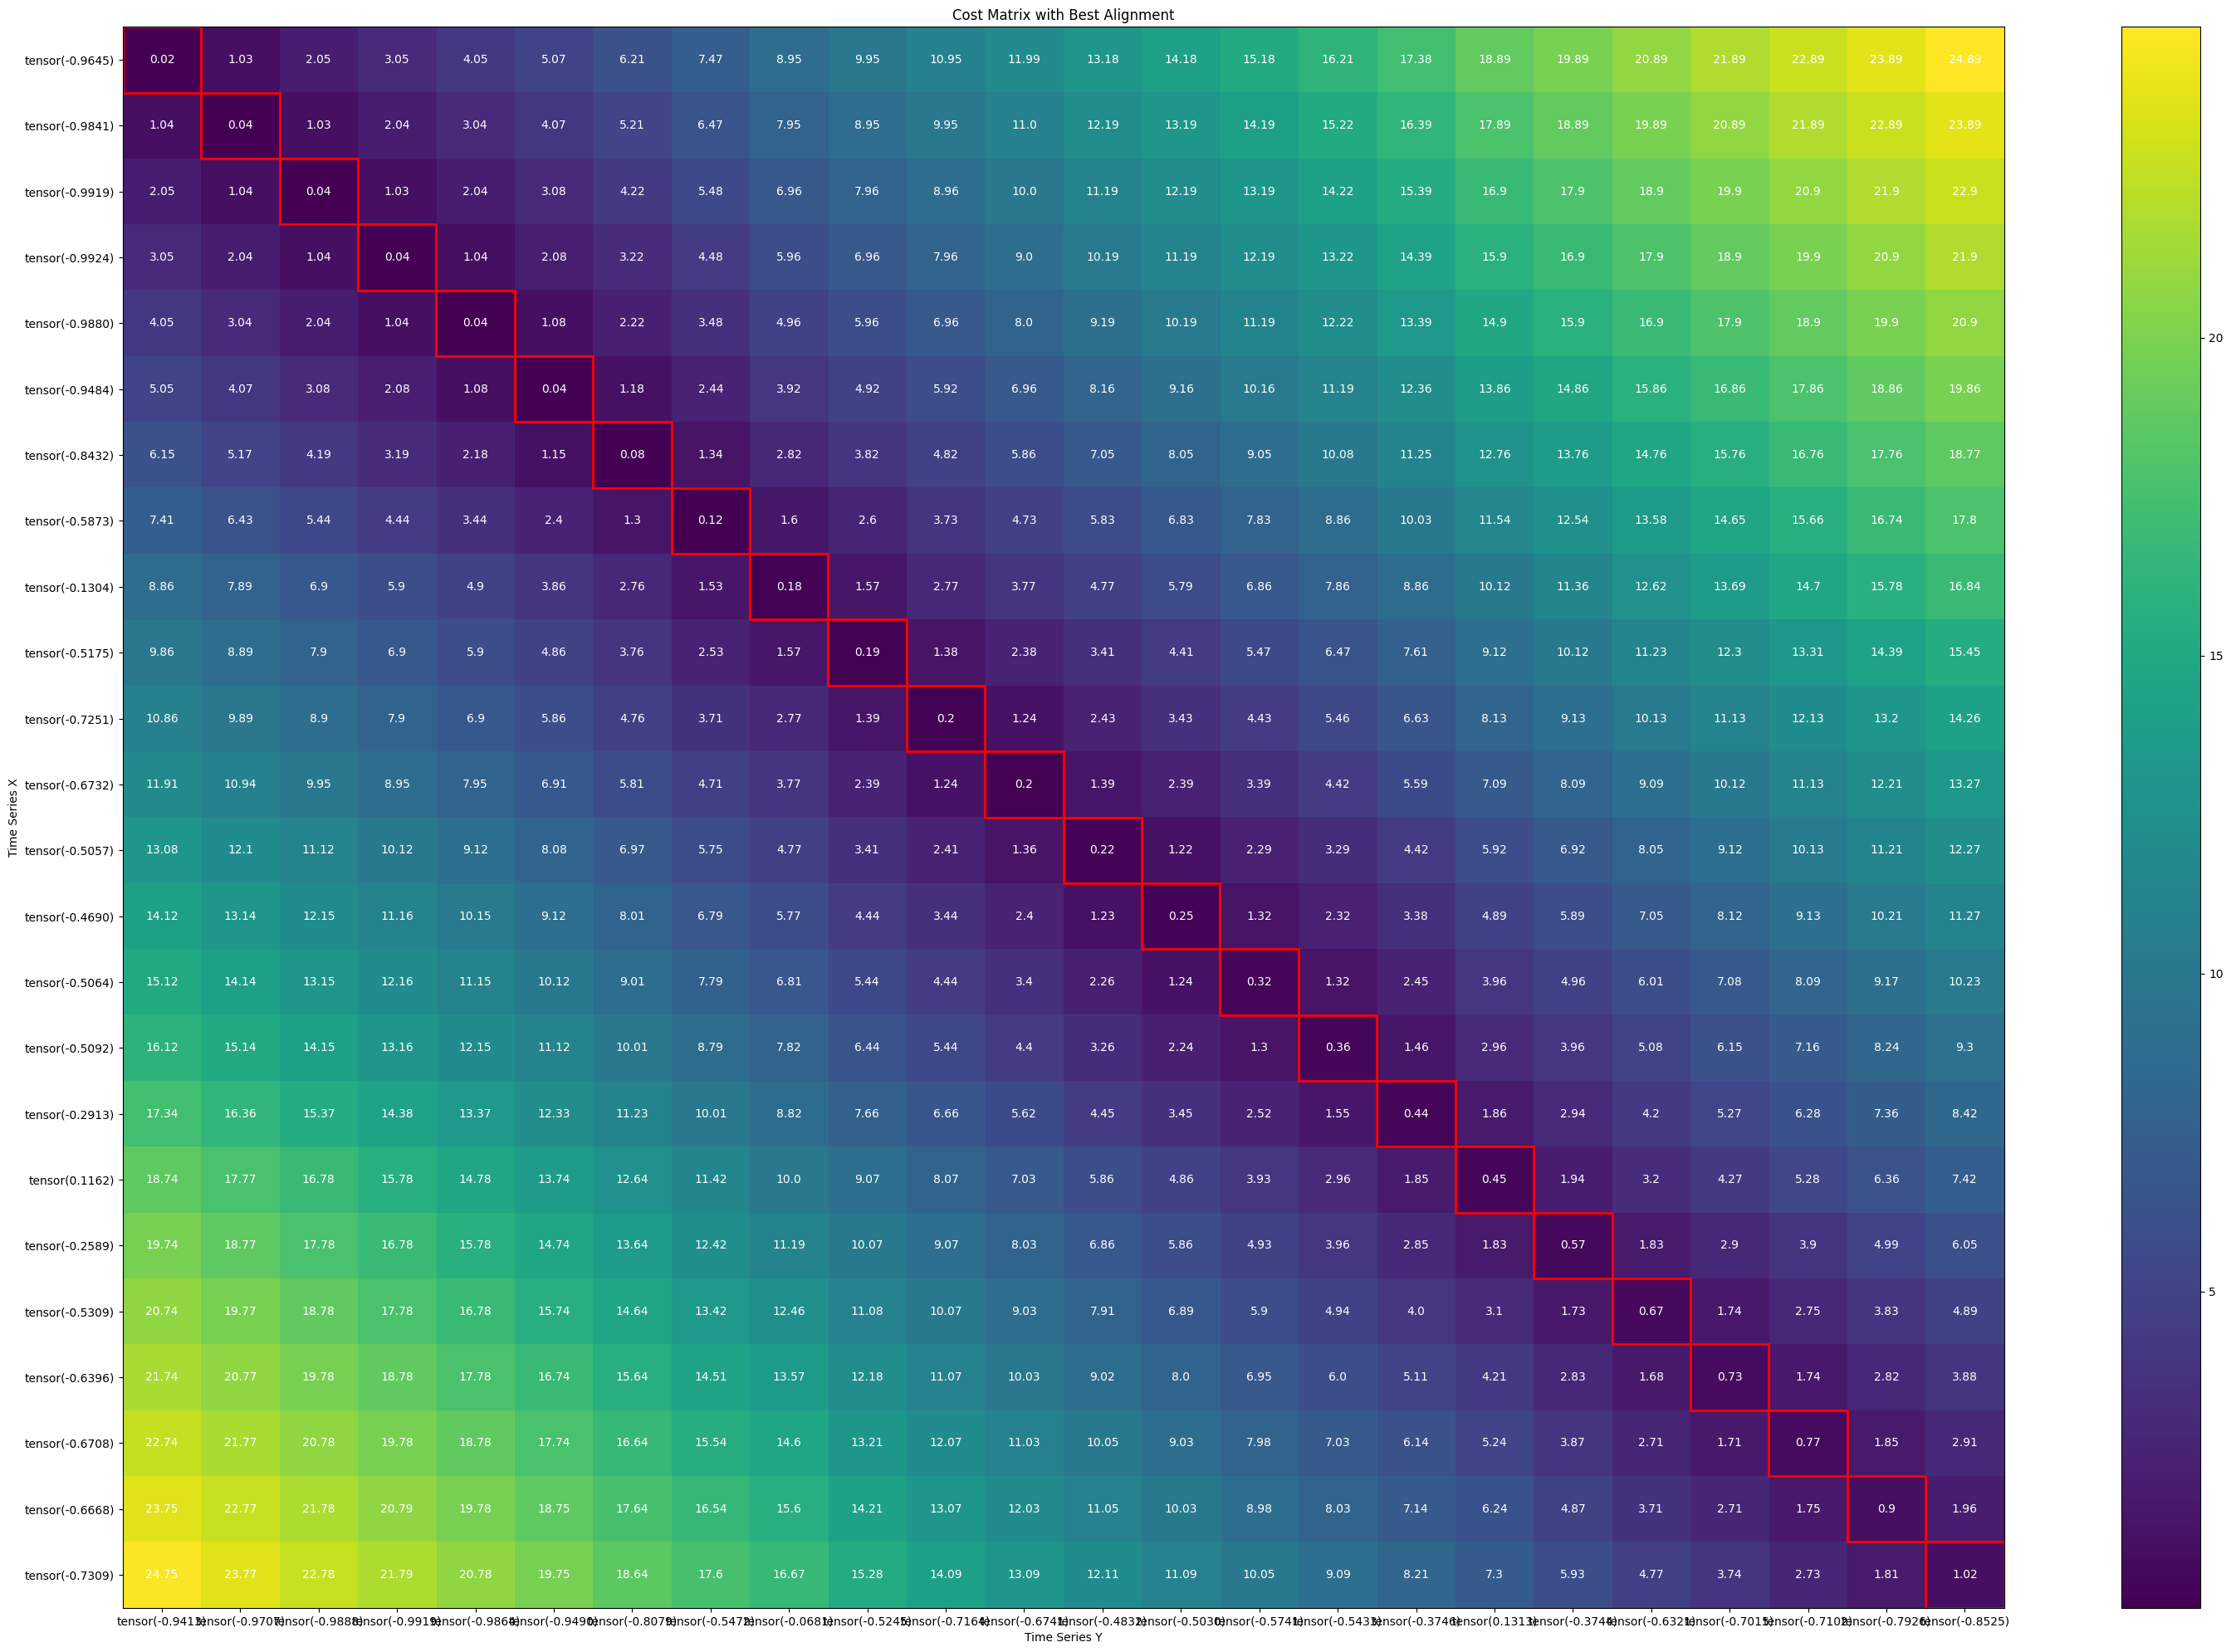

In [9]:
alignment = compute_path(cost_matrix)
plot_cost_matrix(cost_matrix, alignment, X1, X2)

## Barycentre Average

### Funciones

In [10]:
def msm_barycenter_average(X, max_iters=30, c=1.0, tol=1e-5, verbose=False):
    center = msm_medoids(X, c)
    prev_cost = np.inf
    
    for i in range(max_iters):
        center, cost = msm_ba_update(center, X, c, verbose)
        if verbose:
            print(f"Iteration {i+1}: Cost = {cost}")
        
        if abs(prev_cost - cost) < tol:
            if verbose:
                print(f"Convergence reached at iteration {i+1}")
            break
        
        prev_cost = cost
    
    return center

def msm_ba_update(center, X, c, verbose=False):
    n, m = X.shape[0], center.shape[0]
    num_warps = np.zeros(m)
    alignment = np.zeros(m)
    total_cost = 0
    
    for i in range(n):
        dist, cost_matrix = MSM_Distance(X[i], center, c, return_cost=True)
        curr_alignment = compute_path(cost_matrix)
        for j, k in curr_alignment:
            alignment[k] += X[i, j]
            num_warps[k] += 1
        total_cost += dist
    
    new_center = alignment / num_warps
    avg_cost = total_cost / n
    
    if verbose:
        print(f"Average cost: {avg_cost}")
    
    return new_center, avg_cost

def msm_medoids(X, c):
    n = X.shape[0]
    dist_matrix = np.zeros((n, n))
    
    for i in range(n):
        for j in range(n):
            dist_matrix[i, j] = MSM_Distance(X[i], X[j], c)
    
    medoid_index = np.argmin(np.sum(dist_matrix, axis=1))
    return X[medoid_index]

def plot_cluster_with_barycenter(X, barycenter):
    plt.figure(figsize=(10, 6))
    
    # Plot the individual time series in the cluster
    for ts in X:
        plt.plot(ts, color='gray', alpha=0.3, linewidth=1)
    
    # Plot the barycenter time series with a thicker line and higher opacity
    plt.plot(barycenter, color='red', alpha=1.0, linewidth=2, label='Barycenter')
    #plot mean
    plt.plot(np.mean(X, axis=0), color='blue', alpha=1.0, linewidth=2, label='Mean')
    
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title('Cluster with Barycenter')
    plt.legend()
    plt.grid(True)
    plt.show()

### Ejemplo

In [11]:
c = 1
selected_label = 0
n_samples = 10

In [12]:
centers = {k: {} for k in dataset.unique_labels}
for selected_label in dataset.unique_labels:
    selected_label_indices = df.index[df[0] == selected_label].tolist()
    X = df.loc[selected_label_indices].drop(columns=[0]).values
    barycenter = msm_barycenter_average(X, verbose=False)
    centers[selected_label] = {"X": X,"barycenter": barycenter.tolist(), "mean": np.mean(X, axis=0).tolist()}

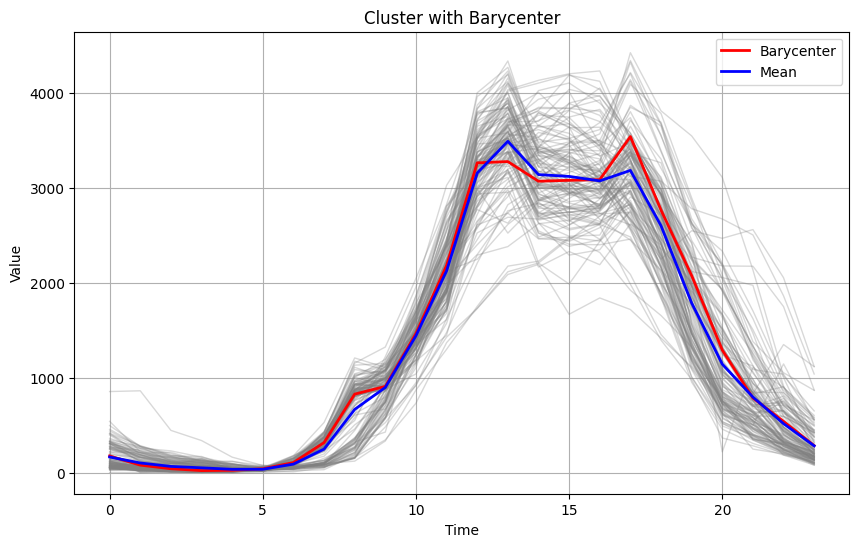

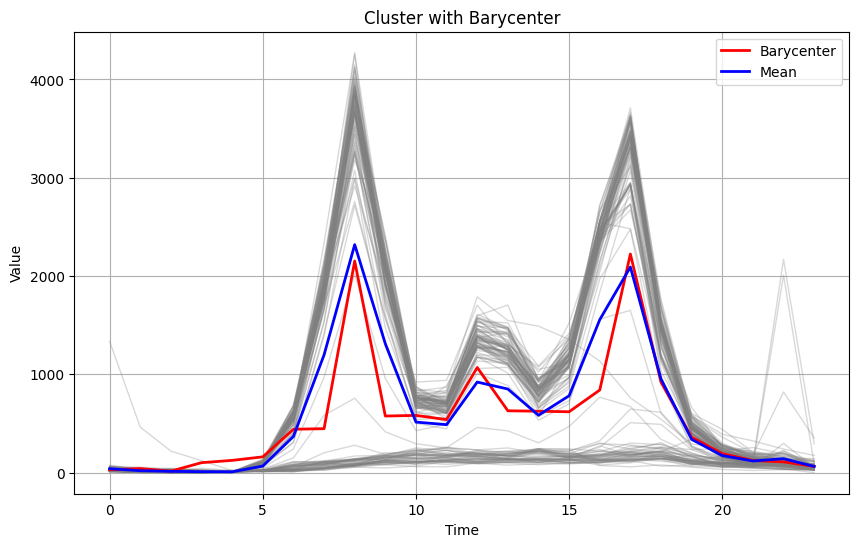

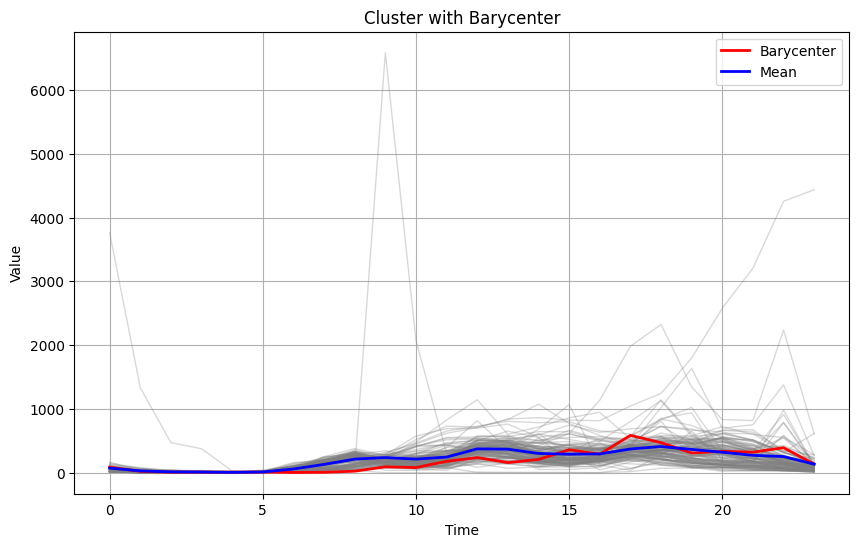

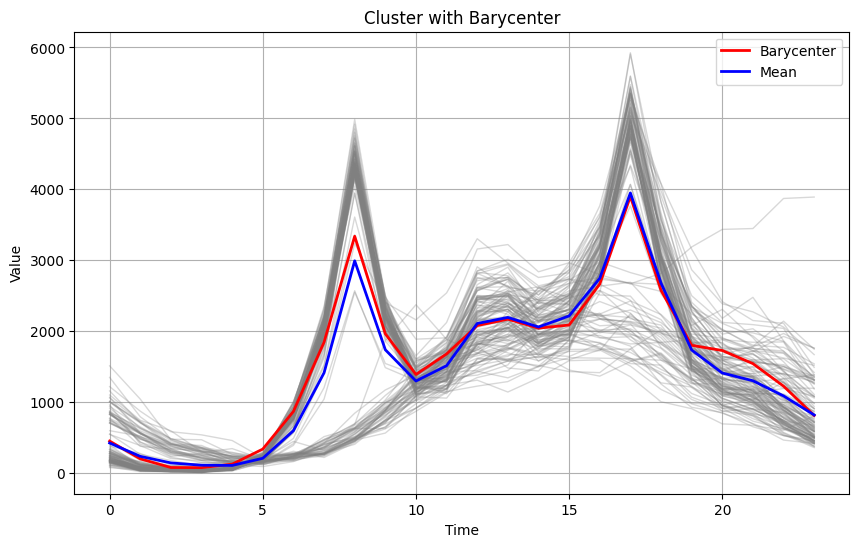

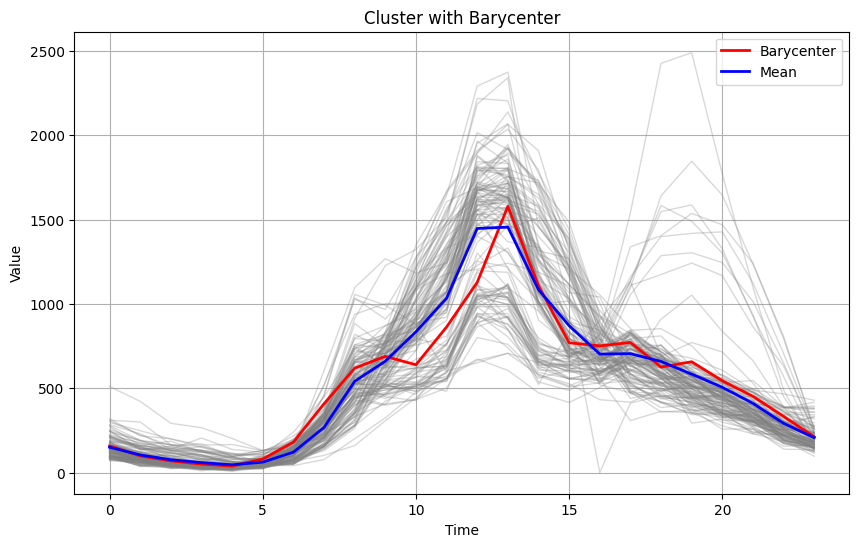

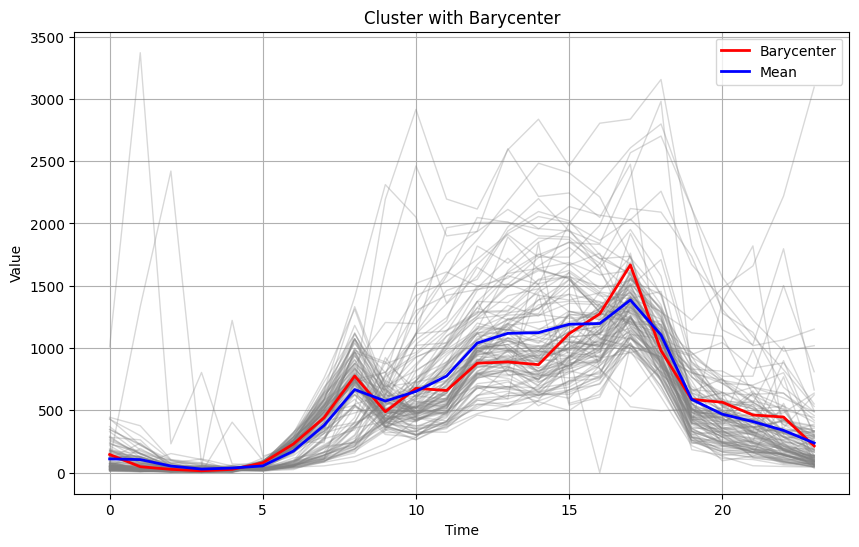

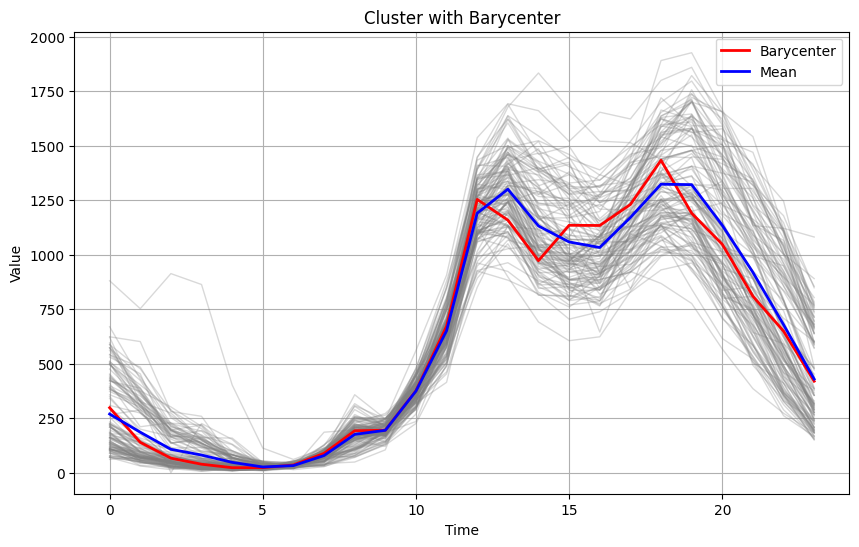

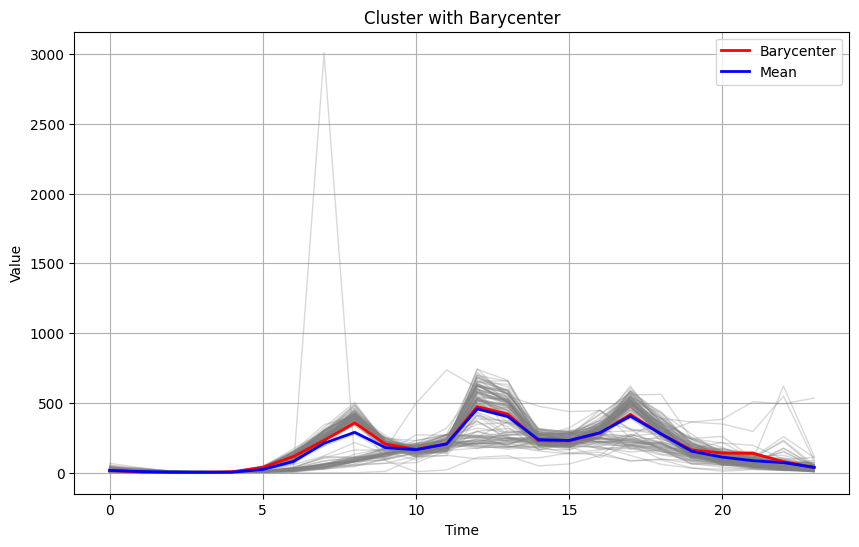

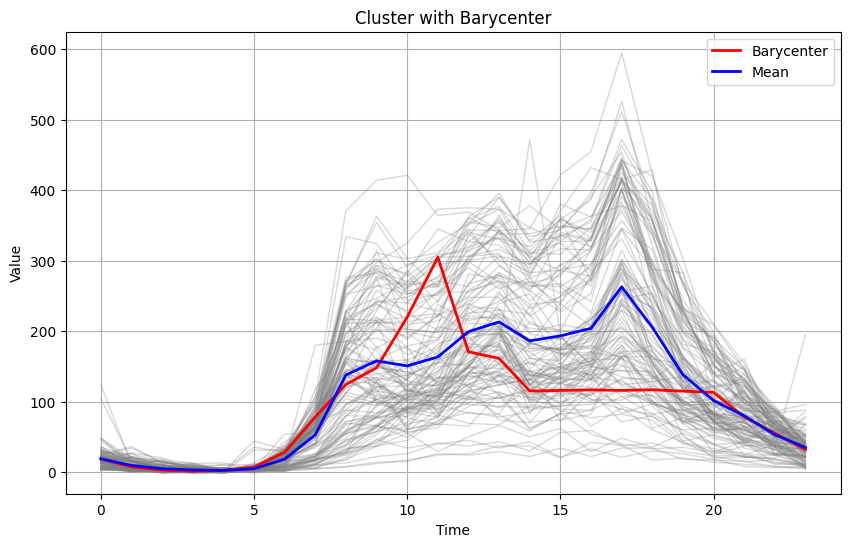

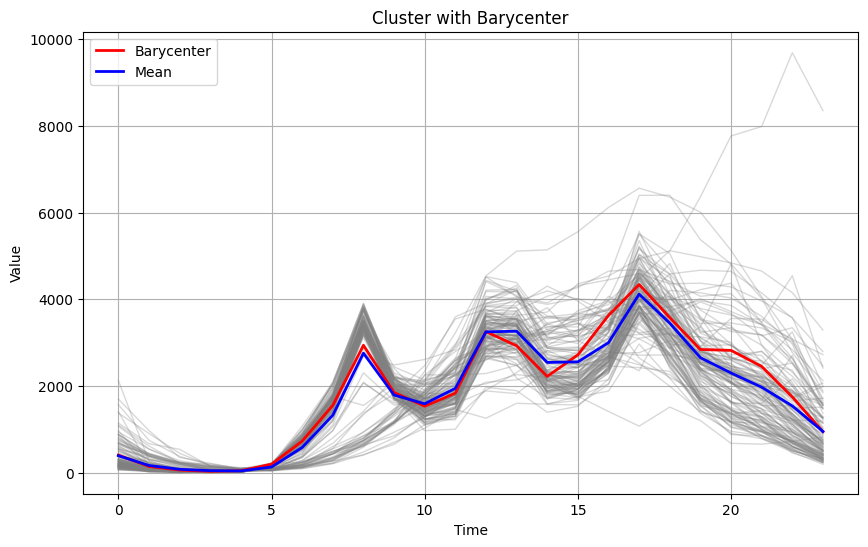

In [13]:
for selected_label in dataset.unique_labels:
    X = centers[selected_label]["X"]
    barycenter = np.array(centers[selected_label]["barycenter"])
    plot_cluster_with_barycenter(X, barycenter)